In [1]:
%cd ~/SSMuLA

/disk2/fli/SSMuLA


In [4]:
%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [32]:
from Bio.PDB import PDBParser, PDBIO
from Bio.PDB.PDBExceptions import PDBConstructionWarning
import warnings
import itertools

# Suppress PDB construction warnings
warnings.simplefilter('ignore', PDBConstructionWarning)

def get_ca_distance(structure, residue1, residue2, chain_id='A'):
    """
    Calculate the C-alpha distance between two residues within a structure object.

    Parameters:
    - structure: PDB structure object.
    - residue1, residue2: Residue numbers (integers) of the residues to measure.
    - chain_id: ID of the chain where the residues are located (default is chain 'A').

    Returns:
    - distance: Distance between the C-alpha atoms of the specified residues.
    """
    # Select chain and residues
    chain = structure[0][chain_id]  # Assume using the first model
    res1 = chain[residue1]
    res2 = chain[residue2]

    # Fetch the 'CA' atoms if they exist
    if 'CA' in res1 and 'CA' in res2:
        ca1 = res1['CA']
        ca2 = res2['CA']
        # Calculate distance
        distance = ca1 - ca2
        return distance
    else:
        return None

def calculate_pairwise_distances(pdb_file, residues_dict, chain_id='A'):
    """
    Calculate pairwise C-alpha distances for a set of residues specified in a dictionary.

    Parameters:
    - pdb_file: Path to the PDB file.
    - residues_dict: Dictionary mapping indices to residue numbers.
    - chain_id: Chain ID to look for residues.

    Returns:
    - distances: Dictionary of tuple (residue pair) to distance.
    """
    # Parse the PDB file
    parser = PDBParser()
    structure = parser.get_structure('PDB', pdb_file)

    # Calculate distances for all pairs
    distances = {}
    for (idx1, res1), (idx2, res2) in itertools.combinations(residues_dict.items(), 2):
        distance = get_ca_distance(structure, res1, res2, chain_id)
        distances[(res1, res2)] = distance

    return distances


In [6]:
from SSMuLA.landscape_global import LIB_INFO_DICT

In [7]:
LIB_INFO_DICT

{'DHFR': {'positions': {1: 26, 2: 27, 3: 28},
  'codons': {1: 'GCC', 2: 'GAT', 3: 'CTC'},
  'AAs': {1: 'A', 2: 'D', 3: 'L'},
  'type': 'Enzymatic activity'},
 'ParD2': {'positions': {1: 61, 2: 64, 3: 80},
  'codons': {1: '', 2: '', 3: ''},
  'AAs': {1: 'I', 2: 'L', 3: 'K'},
  'type': 'Binding'},
 'ParD3': {'positions': {1: 61, 2: 64, 3: 80},
  'codons': {1: '', 2: '', 3: ''},
  'AAs': {1: 'D', 2: 'K', 3: 'E'},
  'type': 'Binding'},
 'GB1': {'positions': {1: 39, 2: 40, 3: 41, 4: 54},
  'codons': {1: '', 2: '', 3: '', 4: ''},
  'AAs': {1: 'V', 2: 'D', 3: 'G', 4: 'V'},
  'type': 'Binding'},
 'TrpB3A': {'positions': {1: 104, 2: 105, 3: 106},
  'codons': {1: 'GCT', 2: 'GAA', 3: 'ACG'},
  'AAs': {1: 'A', 2: 'E', 3: 'T'},
  'type': 'Enzymatic activity'},
 'TrpB3B': {'positions': {1: 105, 2: 106, 3: 107},
  'codons': {1: 'GAA', 2: 'ACG', 3: 'GGT'},
  'AAs': {1: 'E', 2: 'T', 3: 'G'},
  'type': 'Enzymatic activity'},
 'TrpB3C': {'positions': {1: 106, 2: 107, 3: 108},
  'codons': {1: 'ACG', 2: 'G

In [9]:
from glob import glob
import pandas as pd
import numpy as np

In [11]:
df = pd.DataFrame(columns=["lib", "res1", "res2", "dist"])

In [49]:
chain_id = "A"
for lib, l_d in LIB_INFO_DICT.items():
    if "TrpB" not in lib:
        pdb_path = f"data/{lib}/{lib}.pdb"
       
    else:
        pdb_path = "data/TrpB/TrpB.pdb"
        # Parse the PDB file
    
    parser = PDBParser()
    structure = parser.get_structure("PDB", pdb_path)

    for (idx1, res_id1), (idx2, res_id2) in itertools.combinations(
        l_d["positions"].items(), 2
    ):
        df = df._append(
            {
                "lib": lib,
                "res1": res_id1,
                "res2": res_id2,
                "dist": get_ca_distance(structure, res_id1, res_id2, chain_id),
            },
            ignore_index=True,
        )

In [50]:
df

,lib,res1,res2,dist
0,DHFR,26,27,3.858454
1,DHFR,26,28,5.567288
2,DHFR,27,28,3.854704
3,ParD2,61,64,5.123970
4,ParD2,61,80,24.626389
...,...,...,...,...
112,TrpB4,183,227,19.267256
113,TrpB4,183,228,17.429886
114,TrpB4,184,227,15.930763
115,TrpB4,184,228,13.939076


In [56]:
pwd = df[["lib", "dist"]].groupby(["lib"]).agg(["mean", "std"])
pwd.columns = ["mean", "std"]
pwd

,mean,std
lib,,
DHFR,4.393519,0.823078
GB1,5.937460,1.782130
ParD2,17.175402,9.122465
ParD3,17.572769,9.437047
TrpB3A,4.771533,1.531595
TrpB3B,4.877015,1.699147
TrpB3C,4.605879,1.263470
TrpB3D,4.329240,0.809724
TrpB3E,4.458372,1.019296


In [53]:
pwe = pd.read_csv("/disk2/fli/SSMuLA/results/pairwise_epistasis_vis/none/scale2max.csv")
pwe

,lib,n_mut,pos_calc_filter_min,summary_type,epistasis_type,value
0,DHFR,all,none,count,magnitude,538000.000000
1,DHFR,single,none,count,magnitude,24575.000000
2,DHFR,double,none,count,magnitude,285763.000000
3,DHFR,all,none,count,sign,369049.000000
4,DHFR,single,none,count,sign,17743.000000
...,...,...,...,...,...,...
247,TrpB4,single,none,fraction,sign,0.381144
248,TrpB4,double,none,fraction,sign,0.365450
249,TrpB4,all,none,fraction,reciprocal sign,0.092746
250,TrpB4,single,none,fraction,reciprocal sign,0.079531


In [57]:
pwe.pos_calc_filter_min.unique()

array(['none'], dtype=object)

In [54]:
from scipy.stats import spearmanr

In [66]:
print(spearmanr(pwd["mean"], pwe[(pwe["n_mut"]=="all")&(pwe["summary_type"]=="fraction")&(pwe["epistasis_type"]=="magnitude")]["value"]))

SignificanceResult(statistic=0.4021978021978022, pvalue=0.15397442954140356)


In [69]:
lib_stat  = pd.read_csv("results/corr_all/384/boosting|ridge-top96/merge_all.csv")

active_cutoff = 1
active_lib_list = lib_stat[lib_stat["percent_active"]>active_cutoff]["lib"].tolist()

In [71]:
pwd[pwd.index.isin(active_lib_list)]

,mean,std
lib,,
DHFR,4.393519,0.823078
GB1,5.937460,1.782130
ParD2,17.175402,9.122465
ParD3,17.572769,9.437047
TrpB3D,4.329240,0.809724
TrpB3E,4.458372,1.019296
TrpB3F,7.579371,1.970931
TrpB3G,6.835003,2.899602
TrpB3I,4.568492,1.186503


In [70]:
print(spearmanr(pwd[pwd.index.isin(active_lib_list)]["mean"], pwe[(pwe["lib"].isin(active_lib_list))&(pwe["n_mut"]=="all")&(pwe["summary_type"]=="fraction")&(pwe["epistasis_type"]=="magnitude")]["value"]))

SignificanceResult(statistic=0.43030303030303024, pvalue=0.21449233253280775)


In [67]:
import matplotlib.pyplot as plt

%matplotlib inline

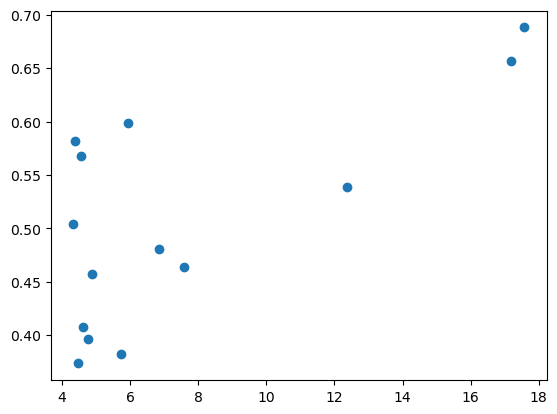

In [68]:
plt.plot(pwd["mean"], pwe[(pwe["n_mut"]=="all")&(pwe["summary_type"]=="fraction")&(pwe["epistasis_type"]=="magnitude")]["value"], "o")

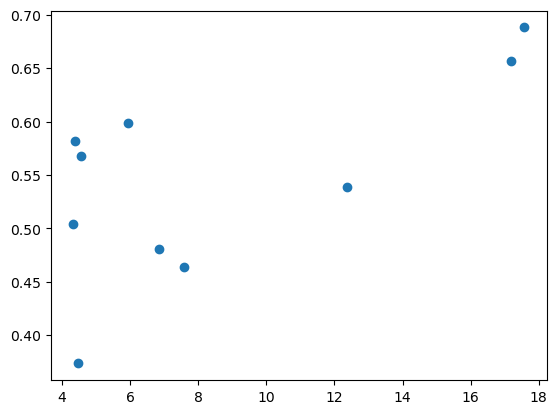

In [73]:
plt.plot(pwd[pwd.index.isin(active_lib_list)]["mean"], pwe[(pwe["lib"].isin(active_lib_list))&(pwe["n_mut"]=="all")&(pwe["summary_type"]=="fraction")&(pwe["epistasis_type"]=="magnitude")]["value"], "o")

In [74]:
pwe = pd.read_csv("/disk2/fli/SSMuLA/results/pairwise_epistasis_vis/active_min/scale2max.csv")
pwe

,lib,summary_type,epistasis_type,value
0,DHFR,count,magnitude,1.827680e+05
1,DHFR,count,sign,7.946800e+04
2,DHFR,count,reciprocal sign,1.405600e+04
3,DHFR,fraction,magnitude,6.615030e-01
4,DHFR,fraction,sign,2.876232e-01
...,...,...,...,...
67,TrpB4,count,sign,1.001345e+06
68,TrpB4,count,reciprocal sign,2.671920e+05
69,TrpB4,fraction,magnitude,5.923642e-01
70,TrpB4,fraction,sign,3.217755e-01


In [77]:
pwd["mean"]

lib
DHFR       4.393519
GB1        5.937460
ParD2     17.175402
ParD3     17.572769
TrpB3A     4.771533
TrpB3B     4.877015
TrpB3C     4.605879
TrpB3D     4.329240
TrpB3E     4.458372
TrpB3F     7.579371
TrpB3G     6.835003
TrpB3H     5.743850
TrpB3I     4.568492
TrpB4     12.356660
Name: mean, dtype: float32

In [78]:
pwe[(pwe["summary_type"]=="fraction")&(pwe["epistasis_type"]=="magnitude")]

,lib,summary_type,epistasis_type,value
3,DHFR,fraction,magnitude,0.661503
9,GB1,fraction,magnitude,0.640882
15,TrpB3A,fraction,magnitude,0.909091
21,TrpB3B,fraction,magnitude,0.000000
27,TrpB3C,fraction,magnitude,1.000000
33,TrpB3D,fraction,magnitude,0.523802
39,TrpB3E,fraction,magnitude,0.692308
45,TrpB3F,fraction,magnitude,0.505051
51,TrpB3G,fraction,magnitude,0.448127
57,TrpB3H,fraction,magnitude,0.400000


In [76]:
print(spearmanr(pwd["mean"], pwe[(pwe["summary_type"]=="fraction")&(pwe["epistasis_type"]=="magnitude")]["value"]))

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 14 and the array at index 1 has size 12